In [1]:
import copy
import json
from datetime import datetime
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from constants import DATA_DIR, MODELS_DIR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import (
    PackedSequence,
    pack_padded_sequence,
    pad_packed_sequence,
    pad_sequence,
)
from torch.utils.data import DataLoader, Dataset, TensorDataset

from astrofit.utils import AsteroidLoader, LightcurveBinner

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
assert torch.cuda.is_available(), "CUDA is not available"

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()

ASTEROIDS_FREQ_DATA_PATH = DATA_DIR / "asteroids_freq_data.json"


In [4]:
with open(ASTEROIDS_FREQ_DATA_PATH, "r") as f_in:
    asteroids_data = json.load(f_in)

filtered_data = {name: data for name, data in asteroids_data.items() if not data["is_failed"]}
len(filtered_data)

163

In [5]:
X_data = []
y_data = []
for data in filtered_data.values():
    tmp = []
    no_splits = len(data["freq_features"]) // 50
    for i in range(no_splits):
        tmp.append(data["freq_features"][50 * i : 50 * (i + 1)])
    
    X_data.append(torch.tensor(tmp))
    y_data.append(data["period"])

y_data = torch.tensor(y_data).unsqueeze(1)

In [6]:
def get_packed_padded_data(data: list[torch.Tensor]):
    seq_len = torch.tensor([len(x) for x in data])
    
    padded = pad_sequence(data, batch_first=True)
    print(f"Padded shape: {padded.shape}")
    
    packed =  pack_padded_sequence(padded, seq_len, batch_first=True, enforce_sorted=False)
    print(f"Packed data shape: {packed.data.shape}")

    return packed

In [7]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state=42)
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 114
Validation size: 34
Test size: 15


In [8]:
y_train.shape

torch.Size([114, 1])

In [9]:
X_train = get_packed_padded_data(X_train)
X_val = get_packed_padded_data(X_val)
X_test = get_packed_padded_data(X_test)


Padded shape: torch.Size([114, 4, 50])
Packed data shape: torch.Size([400, 50])
Padded shape: torch.Size([34, 4, 50])
Packed data shape: torch.Size([121, 50])
Padded shape: torch.Size([15, 4, 50])
Packed data shape: torch.Size([54, 50])


In [10]:
class ModelConfig(TypedDict):
    input_size: int
    hidden_size: int
    num_layers: int
    fc1_size: int
    fc2_size: int
    bidirectional: bool
    dropout: float

In [11]:
class AsteroidLSTM(nn.Module):
    def __init__(self, config: ModelConfig):
        super(AsteroidLSTM, self).__init__()
        self.hidden_size = config["hidden_size"]
        self.num_layers = config["num_layers"]
        self.bidirectional = config["bidirectional"]
        self.lstm = nn.LSTM(
            config["input_size"],
            config["hidden_size"],
            config["num_layers"],
            batch_first=True,
            bidirectional=config["bidirectional"],
            dropout=config["dropout"],
        )

        fc_input_size = config["hidden_size"] * 2 if config["bidirectional"] else config["hidden_size"]
        self.fc1 = nn.Linear(fc_input_size, config["fc1_size"])
        self.fc2 = nn.Linear(config["fc1_size"], config["fc2_size"])
        self.fc3 = nn.Linear(config["fc2_size"], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x: torch.Tensor):
        # Process the packed sequence through the LSTM
        output, _ = self.lstm(x)

        # Unpack the sequence
        output, lengths = pad_packed_sequence(output, batch_first=True)

        # Get the last output for each sequence
        batch_size = output.size(0)
        last_output = output[torch.arange(batch_size), lengths - 1]

        # If bidirectional, concatenate forward and backward last outputs
        if self.bidirectional:
            last_output = torch.cat((last_output[:, : self.hidden_size], last_output[:, self.hidden_size :]), dim=1)

        x = self.relu(self.fc1(last_output))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
class PackedSequenceDataset(Dataset):
    def __init__(self, packed_sequence, targets):
        self.data = packed_sequence
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return idx, self.targets[idx]


def custom_collate_fn(batch):
    indices, targets = zip(*batch)
    return torch.LongTensor(indices), torch.tensor(targets).float()

In [30]:
def train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size,
    num_epochs,
    learning_rate,
    model_suffix: str | None = None,
    patience=100,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoaders
    train_dataset = PackedSequenceDataset(X_train, y_train)
    val_dataset = PackedSequenceDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    best_val_loss = float("inf")
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for indices, y_batch in train_loader:
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            # Create a new PackedSequence for this batch
            X_batch = PackedSequence(
                X_train.data[
                    X_train.batch_sizes[: indices.max() + 1].sum()
                    - X_train.batch_sizes[: indices.max() + 1].sum() : X_train.batch_sizes[: indices.max() + 1].sum()
                ],
                X_train.batch_sizes[: indices.max() + 1],
                X_train.sorted_indices[indices],
                X_train.unsorted_indices[indices],
            )
            X_batch = X_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for indices, y_batch in val_loader:
                y_batch = y_batch.to(device)
                # Create a new PackedSequence for this batch
                X_batch = PackedSequence(
                    X_val.data[
                        X_val.batch_sizes[: indices.max() + 1].sum()
                        - X_val.batch_sizes[: indices.max() + 1].sum() : X_val.batch_sizes[: indices.max() + 1].sum()
                    ],
                    X_val.batch_sizes[: indices.max() + 1],
                    X_val.sorted_indices[indices],
                    X_val.unsorted_indices[indices],
                )
                X_batch = X_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * y_batch.size(0)

        val_loss /= len(val_loader.dataset)

        if model_suffix is not None:
            print(f"\rEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}", end="")

        # Check if this is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0

            if model_suffix is not None:
                torch.save(best_model.state_dict(), MODELS_DIR / f"asteroid_lstm_{model_suffix}.pt")
                print(f"\nNew best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return best_model

In [14]:
def evaluate_model(model, X_test, y_test, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_dataset = PackedSequenceDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for indices, y_batch in test_loader:
            y_batch = y_batch.to(device)

            # Create a new PackedSequence for this batch
            X_batch = PackedSequence(
                X_test.data[
                    X_test.batch_sizes[: indices.max() + 1].sum()
                    - X_test.batch_sizes[: indices.max() + 1].sum() : X_test.batch_sizes[: indices.max() + 1].sum()
                ],
                X_test.batch_sizes[: indices.max() + 1],
                X_test.sorted_indices[indices],
                X_test.unsorted_indices[indices],
            )
            X_batch = X_batch.to(device)

            outputs = model(X_batch)

            all_outputs.extend(outputs.cpu().numpy().squeeze())
            all_targets.extend(y_batch.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(all_targets, all_outputs)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_outputs)
    r2 = r2_score(all_targets, all_outputs)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2 Score: {r2:.4f}")

    return mse, rmse, mae, r2, all_outputs, all_targets

In [15]:
config = ModelConfig(
    input_size=X_train.data.size(-1),
    hidden_size=64,
    num_layers=2,
    fc1_size=64,
    fc2_size=32,
    bidirectional=False,
    dropout=0.1,
)

In [16]:
model = AsteroidLSTM(config).cuda()
model

AsteroidLSTM(
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [17]:
batch_size = 16
num_epochs = 1000
learning_rate = 0.001

In [18]:
train_start = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size,
    num_epochs,
    learning_rate,
    model_suffix=train_start,
)

Epoch 1/1000, Train Loss: 74.7077, Val Loss: 56.9478
New best model saved with validation loss: 56.9478
Epoch 2/1000, Train Loss: 72.6733, Val Loss: 54.1124
New best model saved with validation loss: 54.1124
Epoch 3/1000, Train Loss: 67.6129, Val Loss: 45.1539
New best model saved with validation loss: 45.1539
Epoch 4/1000, Train Loss: 52.9884, Val Loss: 27.0761
New best model saved with validation loss: 27.0761
Epoch 5/1000, Train Loss: 27.6691, Val Loss: 9.4082
New best model saved with validation loss: 9.4082
Epoch 8/1000, Train Loss: 9.1145, Val Loss: 7.240335
New best model saved with validation loss: 7.2403
Epoch 9/1000, Train Loss: 9.4771, Val Loss: 6.4949
New best model saved with validation loss: 6.4949
Epoch 10/1000, Train Loss: 8.9795, Val Loss: 6.4484
New best model saved with validation loss: 6.4484
Epoch 17/1000, Train Loss: 9.1218, Val Loss: 6.14597
New best model saved with validation loss: 6.1459
Epoch 18/1000, Train Loss: 8.8955, Val Loss: 5.9899
New best model saved 

In [19]:
model.load_state_dict(torch.load(MODELS_DIR / f"asteroid_lstm_{train_start}.pt"))
model.eval()

mse, rmse, mae, r2, predictions, true_values = evaluate_model(model, X_test, y_test, batch_size)

Test MSE: 5.8935
Test RMSE: 2.4276
Test MAE: 2.0517
Test R2 Score: 0.0128


In [20]:
for i in range(10):
    print(f"True: {true_values[i]:8.4f}, Predicted: {predictions[i]:8.4f}")

True:   4.8290, Predicted:   8.1891
True:   8.3899, Predicted:   7.3521
True:  12.3214, Predicted:   8.0293
True:   4.8040, Predicted:   7.0223
True:   3.9682, Predicted:   6.8891
True:   5.5296, Predicted:   6.0910
True:   8.9806, Predicted:   7.2861
True:   7.2400, Predicted:   8.3655
True:   4.4404, Predicted:   8.5389
True:   7.2801, Predicted:   7.9576


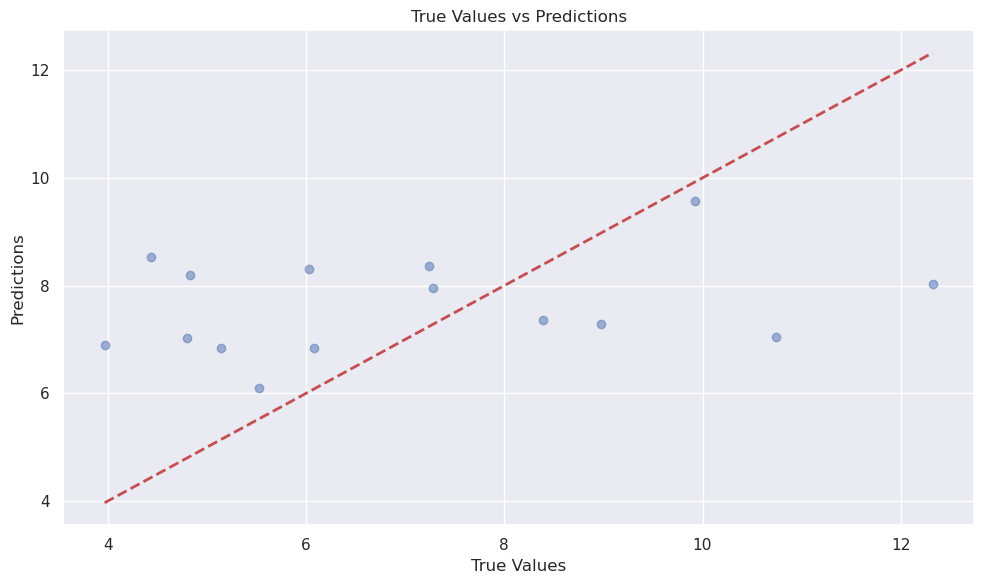

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.tight_layout()
plt.show()

In [22]:
import optuna
from optuna.trial import TrialState

/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def objective(trial):
    # Define the hyperparameters to tune
    config = ModelConfig(
        input_size=50,  # Assuming this is fixed
        hidden_size=trial.suggest_int('hidden_size', 32, 256),
        num_layers=trial.suggest_int('num_layers', 1, 3),
        fc1_size=trial.suggest_int('fc1_size', 32, 256),
        fc2_size=trial.suggest_int('fc2_size', 16, 128),
        bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
        dropout=trial.suggest_float('dropout', 0.1, 0.5)
    )
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create model with the suggested hyperparameters
    model = AsteroidLSTM(config)

    # Train the model
    best_model = train_model(model, X_train, y_train, X_val, y_val, batch_size, num_epochs=200, learning_rate=learning_rate)

    # Evaluate the model
    _, _, mae, _, _, _ = evaluate_model(best_model, X_val, y_val, batch_size)

    return mae


In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2024-06-22 16:59:37,201] A new study created in memory with name: no-name-275b6cc6-76b2-49d7-a95c-5a56eddbefbd
/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46360156540011477 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 16:59:38,116] Trial 0 finished with value: 1.9480981826782227 and parameters: {'hidden_size': 163, 'num_layers': 1, 'fc1_size': 218, 'fc2_size': 43, 'bidirectional': False, 'dropout': 0.46360156540011477, 'learning_rate': 0.0005133720693293112, 'batch_size': 128}. Best is trial 0 with value: 1.9480981826782227.


Test MSE: 6.0287
Test RMSE: 2.4553
Test MAE: 1.9481
Test R2 Score: -0.2748


[I 2024-06-22 16:59:40,419] Trial 1 finished with value: 2.327924966812134 and parameters: {'hidden_size': 145, 'num_layers': 3, 'fc1_size': 248, 'fc2_size': 103, 'bidirectional': True, 'dropout': 0.45147674349457523, 'learning_rate': 5.347998516491998e-05, 'batch_size': 64}. Best is trial 0 with value: 1.9480981826782227.


Test MSE: 7.9090
Test RMSE: 2.8123
Test MAE: 2.3279
Test R2 Score: -0.6724


[I 2024-06-22 16:59:42,416] Trial 2 finished with value: 1.639225959777832 and parameters: {'hidden_size': 80, 'num_layers': 3, 'fc1_size': 134, 'fc2_size': 74, 'bidirectional': True, 'dropout': 0.46561431111707907, 'learning_rate': 0.00044262256300616967, 'batch_size': 64}. Best is trial 2 with value: 1.639225959777832.


Test MSE: 3.8900
Test RMSE: 1.9723
Test MAE: 1.6392
Test R2 Score: 0.1774


[I 2024-06-22 16:59:46,348] Trial 3 finished with value: 1.492121934890747 and parameters: {'hidden_size': 137, 'num_layers': 3, 'fc1_size': 76, 'fc2_size': 89, 'bidirectional': True, 'dropout': 0.17269038579882437, 'learning_rate': 0.0006680329028211281, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.1796
Test RMSE: 1.7831
Test MAE: 1.4921
Test R2 Score: 0.3277


[I 2024-06-22 16:59:51,916] Trial 4 finished with value: 1.7498517036437988 and parameters: {'hidden_size': 249, 'num_layers': 2, 'fc1_size': 51, 'fc2_size': 30, 'bidirectional': False, 'dropout': 0.4657355167423325, 'learning_rate': 0.0055398130465371285, 'batch_size': 16}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.5829
Test RMSE: 2.1408
Test MAE: 1.7499
Test R2 Score: 0.0309


[I 2024-06-22 16:59:57,283] Trial 5 finished with value: 1.7727352380752563 and parameters: {'hidden_size': 48, 'num_layers': 3, 'fc1_size': 174, 'fc2_size': 68, 'bidirectional': False, 'dropout': 0.3464178880220391, 'learning_rate': 0.07756346184650902, 'batch_size': 16}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.6828
Test RMSE: 2.1640
Test MAE: 1.7727
Test R2 Score: 0.0098


[I 2024-06-22 16:59:58,222] Trial 6 finished with value: 1.7426501512527466 and parameters: {'hidden_size': 160, 'num_layers': 3, 'fc1_size': 72, 'fc2_size': 79, 'bidirectional': False, 'dropout': 0.45963769104489394, 'learning_rate': 0.009318801953769629, 'batch_size': 128}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.3807
Test RMSE: 2.0930
Test MAE: 1.7427
Test R2 Score: 0.0737


[I 2024-06-22 17:00:02,913] Trial 7 finished with value: 1.838261604309082 and parameters: {'hidden_size': 200, 'num_layers': 3, 'fc1_size': 134, 'fc2_size': 79, 'bidirectional': True, 'dropout': 0.206916287586281, 'learning_rate': 0.0785514393846314, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.8035
Test RMSE: 2.1917
Test MAE: 1.8383
Test R2 Score: -0.0157


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4846273580715067 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:03,811] Trial 8 finished with value: 1.7664391994476318 and parameters: {'hidden_size': 83, 'num_layers': 1, 'fc1_size': 176, 'fc2_size': 29, 'bidirectional': True, 'dropout': 0.4846273580715067, 'learning_rate': 0.007151909737753669, 'batch_size': 128}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.7141
Test RMSE: 2.1712
Test MAE: 1.7664
Test R2 Score: 0.0032


[I 2024-06-22 17:00:06,660] Trial 9 finished with value: 1.550919771194458 and parameters: {'hidden_size': 244, 'num_layers': 2, 'fc1_size': 206, 'fc2_size': 43, 'bidirectional': False, 'dropout': 0.2900436734895644, 'learning_rate': 0.0013686414988884244, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.2303
Test RMSE: 1.7973
Test MAE: 1.5509
Test R2 Score: 0.3169


[I 2024-06-22 17:00:10,044] Trial 10 finished with value: 2.4117870330810547 and parameters: {'hidden_size': 101, 'num_layers': 2, 'fc1_size': 89, 'fc2_size': 123, 'bidirectional': True, 'dropout': 0.11603567822140898, 'learning_rate': 1.6542021593919237e-05, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 9.4148
Test RMSE: 3.0683
Test MAE: 2.4118
Test R2 Score: -0.9908


[I 2024-06-22 17:00:13,037] Trial 11 finished with value: 1.9681212902069092 and parameters: {'hidden_size': 247, 'num_layers': 2, 'fc1_size': 32, 'fc2_size': 56, 'bidirectional': False, 'dropout': 0.2585672570489195, 'learning_rate': 0.00016150306108518952, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 5.6580
Test RMSE: 2.3786
Test MAE: 1.9681
Test R2 Score: -0.1964


[I 2024-06-22 17:00:16,740] Trial 12 finished with value: 1.557310938835144 and parameters: {'hidden_size': 206, 'num_layers': 2, 'fc1_size': 104, 'fc2_size': 104, 'bidirectional': True, 'dropout': 0.16930249265517755, 'learning_rate': 0.0017612282531596405, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.8210
Test RMSE: 1.9548
Test MAE: 1.5573
Test R2 Score: 0.1920


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2989357171536844 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:19,201] Trial 13 finished with value: 1.522722840309143 and parameters: {'hidden_size': 195, 'num_layers': 1, 'fc1_size': 198, 'fc2_size': 103, 'bidirectional': False, 'dropout': 0.2989357171536844, 'learning_rate': 0.0017190722838485736, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.1618
Test RMSE: 2.0400
Test MAE: 1.5227
Test R2 Score: 0.1200


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3675819073687911 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:22,089] Trial 14 finished with value: 1.958186149597168 and parameters: {'hidden_size': 194, 'num_layers': 1, 'fc1_size': 154, 'fc2_size': 99, 'bidirectional': True, 'dropout': 0.3675819073687911, 'learning_rate': 0.00014198802300014596, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 5.8498
Test RMSE: 2.4186
Test MAE: 1.9582
Test R2 Score: -0.2370


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24577486052105785 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:24,552] Trial 15 finished with value: 1.5431194305419922 and parameters: {'hidden_size': 104, 'num_layers': 1, 'fc1_size': 115, 'fc2_size': 121, 'bidirectional': False, 'dropout': 0.24577486052105785, 'learning_rate': 0.00320781244105386, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.9644
Test RMSE: 1.9911
Test MAE: 1.5431
Test R2 Score: 0.1617


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10171792999063795 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:27,425] Trial 16 finished with value: 1.6609234809875488 and parameters: {'hidden_size': 125, 'num_layers': 1, 'fc1_size': 208, 'fc2_size': 90, 'bidirectional': True, 'dropout': 0.10171792999063795, 'learning_rate': 0.02087541699590732, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.5811
Test RMSE: 1.8924
Test MAE: 1.6609
Test R2 Score: 0.2428


[I 2024-06-22 17:00:28,911] Trial 17 finished with value: 1.5871628522872925 and parameters: {'hidden_size': 179, 'num_layers': 2, 'fc1_size': 255, 'fc2_size': 114, 'bidirectional': False, 'dropout': 0.3652236922542259, 'learning_rate': 0.0005335120293452649, 'batch_size': 64}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.3266
Test RMSE: 1.8239
Test MAE: 1.5872
Test R2 Score: 0.2966


[I 2024-06-22 17:00:38,764] Trial 18 finished with value: 1.8961931467056274 and parameters: {'hidden_size': 216, 'num_layers': 3, 'fc1_size': 180, 'fc2_size': 91, 'bidirectional': True, 'dropout': 0.16198800631357935, 'learning_rate': 0.00012276323719277198, 'batch_size': 16}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 5.3392
Test RMSE: 2.3107
Test MAE: 1.8962
Test R2 Score: -0.1290


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3209866283540321 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:41,375] Trial 19 finished with value: 3.8359482288360596 and parameters: {'hidden_size': 133, 'num_layers': 1, 'fc1_size': 62, 'fc2_size': 62, 'bidirectional': False, 'dropout': 0.3209866283540321, 'learning_rate': 1.30745430799493e-05, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 21.4448
Test RMSE: 4.6308
Test MAE: 3.8359
Test R2 Score: -3.5347


[I 2024-06-22 17:00:44,134] Trial 20 finished with value: 1.7500219345092773 and parameters: {'hidden_size': 222, 'num_layers': 2, 'fc1_size': 152, 'fc2_size': 88, 'bidirectional': False, 'dropout': 0.41075119390024956, 'learning_rate': 0.020902058845422587, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.5103
Test RMSE: 2.1237
Test MAE: 1.7500
Test R2 Score: 0.0463


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2434172761013567 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:46,677] Trial 21 finished with value: 1.7352410554885864 and parameters: {'hidden_size': 110, 'num_layers': 1, 'fc1_size': 108, 'fc2_size': 127, 'bidirectional': False, 'dropout': 0.2434172761013567, 'learning_rate': 0.002642011520532896, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.5582
Test RMSE: 2.1350
Test MAE: 1.7352
Test R2 Score: 0.0361


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22030147123266236 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:49,294] Trial 22 finished with value: 1.7075026035308838 and parameters: {'hidden_size': 43, 'num_layers': 1, 'fc1_size': 114, 'fc2_size': 114, 'bidirectional': False, 'dropout': 0.22030147123266236, 'learning_rate': 0.0026585539825163033, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 3.9353
Test RMSE: 1.9838
Test MAE: 1.7075
Test R2 Score: 0.1679


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2780071566606313 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:51,934] Trial 23 finished with value: 1.7865042686462402 and parameters: {'hidden_size': 152, 'num_layers': 1, 'fc1_size': 83, 'fc2_size': 117, 'bidirectional': False, 'dropout': 0.2780071566606313, 'learning_rate': 0.000675849102882954, 'batch_size': 32}. Best is trial 3 with value: 1.492121934890747.


Test MSE: 4.7819
Test RMSE: 2.1868
Test MAE: 1.7865
Test R2 Score: -0.0112


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19179324031728026 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:54,499] Trial 24 finished with value: 1.4496734142303467 and parameters: {'hidden_size': 177, 'num_layers': 1, 'fc1_size': 114, 'fc2_size': 109, 'bidirectional': False, 'dropout': 0.19179324031728026, 'learning_rate': 0.0030051065527327636, 'batch_size': 32}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.1238
Test RMSE: 1.7674
Test MAE: 1.4497
Test R2 Score: 0.3395


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16918625058127418 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:00:57,107] Trial 25 finished with value: 2.038983106613159 and parameters: {'hidden_size': 177, 'num_layers': 1, 'fc1_size': 91, 'fc2_size': 108, 'bidirectional': False, 'dropout': 0.16918625058127418, 'learning_rate': 0.00025776914421680926, 'batch_size': 32}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 6.7314
Test RMSE: 2.5945
Test MAE: 2.0390
Test R2 Score: -0.4234


[I 2024-06-22 17:00:58,945] Trial 26 finished with value: 1.7481238842010498 and parameters: {'hidden_size': 177, 'num_layers': 2, 'fc1_size': 228, 'fc2_size': 94, 'bidirectional': True, 'dropout': 0.13845822056171617, 'learning_rate': 0.0011408938965530725, 'batch_size': 64}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 4.2568
Test RMSE: 2.0632
Test MAE: 1.7481
Test R2 Score: 0.0999


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19949569445256152 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:01:03,821] Trial 27 finished with value: 2.3983120918273926 and parameters: {'hidden_size': 130, 'num_layers': 1, 'fc1_size': 45, 'fc2_size': 83, 'bidirectional': False, 'dropout': 0.19949569445256152, 'learning_rate': 4.3458025020829866e-05, 'batch_size': 16}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 8.8469
Test RMSE: 2.9744
Test MAE: 2.3983
Test R2 Score: -0.8708


[I 2024-06-22 17:01:05,549] Trial 28 finished with value: 1.5035377740859985 and parameters: {'hidden_size': 226, 'num_layers': 3, 'fc1_size': 190, 'fc2_size': 109, 'bidirectional': True, 'dropout': 0.3107113577138636, 'learning_rate': 0.02172041374004019, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.1848
Test RMSE: 1.7846
Test MAE: 1.5035
Test R2 Score: 0.3266


[I 2024-06-22 17:01:07,358] Trial 29 finished with value: 1.794289231300354 and parameters: {'hidden_size': 230, 'num_layers': 3, 'fc1_size': 137, 'fc2_size': 109, 'bidirectional': True, 'dropout': 0.13626422313367131, 'learning_rate': 0.020833951474906638, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 4.6289
Test RMSE: 2.1515
Test MAE: 1.7943
Test R2 Score: 0.0212


[I 2024-06-22 17:01:08,727] Trial 30 finished with value: 1.5159085988998413 and parameters: {'hidden_size': 164, 'num_layers': 3, 'fc1_size': 230, 'fc2_size': 53, 'bidirectional': True, 'dropout': 0.32446782913464767, 'learning_rate': 0.04070679988718762, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.3779
Test RMSE: 1.8379
Test MAE: 1.5159
Test R2 Score: 0.2857


[I 2024-06-22 17:01:10,105] Trial 31 finished with value: 1.4828732013702393 and parameters: {'hidden_size': 165, 'num_layers': 3, 'fc1_size': 231, 'fc2_size': 52, 'bidirectional': True, 'dropout': 0.32903550738329557, 'learning_rate': 0.037013270065024285, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.1403
Test RMSE: 1.7721
Test MAE: 1.4829
Test R2 Score: 0.3360


[I 2024-06-22 17:01:11,488] Trial 32 finished with value: 1.6194976568222046 and parameters: {'hidden_size': 170, 'num_layers': 3, 'fc1_size': 238, 'fc2_size': 37, 'bidirectional': True, 'dropout': 0.37958688847470495, 'learning_rate': 0.011415975277395534, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.6105
Test RMSE: 1.9001
Test MAE: 1.6195
Test R2 Score: 0.2365


[I 2024-06-22 17:01:12,779] Trial 33 finished with value: 1.7456059455871582 and parameters: {'hidden_size': 150, 'num_layers': 3, 'fc1_size': 191, 'fc2_size': 97, 'bidirectional': True, 'dropout': 0.4234022082226808, 'learning_rate': 0.04004146823426951, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 4.3687
Test RMSE: 2.0901
Test MAE: 1.7456
Test R2 Score: 0.0762


[I 2024-06-22 17:01:14,062] Trial 34 finished with value: 1.6212186813354492 and parameters: {'hidden_size': 140, 'num_layers': 3, 'fc1_size': 218, 'fc2_size': 70, 'bidirectional': True, 'dropout': 0.3219900771627947, 'learning_rate': 0.00379720818155749, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.4941
Test RMSE: 1.8692
Test MAE: 1.6212
Test R2 Score: 0.2612


[I 2024-06-22 17:01:15,487] Trial 35 finished with value: 1.7635269165039062 and parameters: {'hidden_size': 187, 'num_layers': 3, 'fc1_size': 125, 'fc2_size': 49, 'bidirectional': True, 'dropout': 0.2696802890513266, 'learning_rate': 0.04003316640177383, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 4.6088
Test RMSE: 2.1468
Test MAE: 1.7635
Test R2 Score: 0.0254


[I 2024-06-22 17:01:17,196] Trial 36 finished with value: 1.8345308303833008 and parameters: {'hidden_size': 231, 'num_layers': 3, 'fc1_size': 162, 'fc2_size': 22, 'bidirectional': True, 'dropout': 0.22696669301236821, 'learning_rate': 0.012007997546723078, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 4.7883
Test RMSE: 2.1882
Test MAE: 1.8345
Test R2 Score: -0.0125


[I 2024-06-22 17:01:19,266] Trial 37 finished with value: 1.5523091554641724 and parameters: {'hidden_size': 122, 'num_layers': 3, 'fc1_size': 74, 'fc2_size': 83, 'bidirectional': True, 'dropout': 0.18960072363954833, 'learning_rate': 0.005165541980046223, 'batch_size': 64}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.2650
Test RMSE: 1.8069
Test MAE: 1.5523
Test R2 Score: 0.3096


[I 2024-06-22 17:01:20,616] Trial 38 finished with value: 1.9315645694732666 and parameters: {'hidden_size': 157, 'num_layers': 3, 'fc1_size': 97, 'fc2_size': 75, 'bidirectional': True, 'dropout': 0.34127517594569884, 'learning_rate': 0.00033916647346525703, 'batch_size': 128}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 5.4853
Test RMSE: 2.3421
Test MAE: 1.9316
Test R2 Score: -0.1599


[I 2024-06-22 17:01:32,452] Trial 39 finished with value: 1.4801875352859497 and parameters: {'hidden_size': 256, 'num_layers': 3, 'fc1_size': 239, 'fc2_size': 63, 'bidirectional': True, 'dropout': 0.42077610314065816, 'learning_rate': 0.0007968306034195894, 'batch_size': 16}. Best is trial 24 with value: 1.4496734142303467.


Test MSE: 3.4231
Test RMSE: 1.8502
Test MAE: 1.4802
Test R2 Score: 0.2762


[I 2024-06-22 17:01:38,702] Trial 40 finished with value: 1.4417904615402222 and parameters: {'hidden_size': 59, 'num_layers': 2, 'fc1_size': 256, 'fc2_size': 61, 'bidirectional': True, 'dropout': 0.42893450053849136, 'learning_rate': 0.0007732117777888663, 'batch_size': 16}. Best is trial 40 with value: 1.4417904615402222.


Test MSE: 3.1072
Test RMSE: 1.7627
Test MAE: 1.4418
Test R2 Score: 0.3430


[I 2024-06-22 17:01:45,005] Trial 41 finished with value: 1.4355849027633667 and parameters: {'hidden_size': 57, 'num_layers': 2, 'fc1_size': 246, 'fc2_size': 56, 'bidirectional': True, 'dropout': 0.4331366922040594, 'learning_rate': 0.0008272131288299557, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.2364
Test RMSE: 1.7990
Test MAE: 1.4356
Test R2 Score: 0.3156


[I 2024-06-22 17:01:51,348] Trial 42 finished with value: 1.502321720123291 and parameters: {'hidden_size': 63, 'num_layers': 2, 'fc1_size': 245, 'fc2_size': 64, 'bidirectional': True, 'dropout': 0.4244101096057846, 'learning_rate': 0.0008388598947301599, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.4529
Test RMSE: 1.8582
Test MAE: 1.5023
Test R2 Score: 0.2698


[I 2024-06-22 17:01:57,713] Trial 43 finished with value: 1.6584076881408691 and parameters: {'hidden_size': 57, 'num_layers': 2, 'fc1_size': 252, 'fc2_size': 61, 'bidirectional': True, 'dropout': 0.49600422592340004, 'learning_rate': 0.00037239704451038356, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.7397
Test RMSE: 1.9338
Test MAE: 1.6584
Test R2 Score: 0.2092


[I 2024-06-22 17:02:04,156] Trial 44 finished with value: 1.617823600769043 and parameters: {'hidden_size': 79, 'num_layers': 2, 'fc1_size': 238, 'fc2_size': 44, 'bidirectional': True, 'dropout': 0.44546232171855177, 'learning_rate': 0.00022928499617545507, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.9235
Test RMSE: 1.9808
Test MAE: 1.6178
Test R2 Score: 0.1703


[I 2024-06-22 17:02:10,385] Trial 45 finished with value: 1.5005215406417847 and parameters: {'hidden_size': 36, 'num_layers': 2, 'fc1_size': 218, 'fc2_size': 56, 'bidirectional': True, 'dropout': 0.3888198753452063, 'learning_rate': 0.0010171174970487662, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.2462
Test RMSE: 1.8017
Test MAE: 1.5005
Test R2 Score: 0.3136


[I 2024-06-22 17:02:16,631] Trial 46 finished with value: 1.6154568195343018 and parameters: {'hidden_size': 66, 'num_layers': 2, 'fc1_size': 244, 'fc2_size': 51, 'bidirectional': True, 'dropout': 0.4415066518093604, 'learning_rate': 0.001807603921088679, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.9063
Test RMSE: 1.9764
Test MAE: 1.6155
Test R2 Score: 0.1740


[I 2024-06-22 17:02:22,991] Trial 47 finished with value: 1.768977165222168 and parameters: {'hidden_size': 93, 'num_layers': 2, 'fc1_size': 232, 'fc2_size': 67, 'bidirectional': True, 'dropout': 0.40996079634983407, 'learning_rate': 7.928902970172133e-05, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 4.3572
Test RMSE: 2.0874
Test MAE: 1.7690
Test R2 Score: 0.0786


[I 2024-06-22 17:02:29,530] Trial 48 finished with value: 1.4933273792266846 and parameters: {'hidden_size': 76, 'num_layers': 2, 'fc1_size': 212, 'fc2_size': 38, 'bidirectional': True, 'dropout': 0.4750029350671737, 'learning_rate': 0.0006160485454018284, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.2831
Test RMSE: 1.8119
Test MAE: 1.4933
Test R2 Score: 0.3058


[I 2024-06-22 17:02:37,350] Trial 49 finished with value: 1.4719305038452148 and parameters: {'hidden_size': 209, 'num_layers': 2, 'fc1_size': 254, 'fc2_size': 74, 'bidirectional': True, 'dropout': 0.3496441752387176, 'learning_rate': 0.006022870097517079, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.4044
Test RMSE: 1.8451
Test MAE: 1.4719
Test R2 Score: 0.2801


[I 2024-06-22 17:02:45,555] Trial 50 finished with value: 1.5792617797851562 and parameters: {'hidden_size': 238, 'num_layers': 2, 'fc1_size': 253, 'fc2_size': 74, 'bidirectional': True, 'dropout': 0.3950436022988183, 'learning_rate': 0.005054889717930911, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.6807
Test RMSE: 1.9185
Test MAE: 1.5793
Test R2 Score: 0.2217


[I 2024-06-22 17:02:53,326] Trial 51 finished with value: 1.700512409210205 and parameters: {'hidden_size': 215, 'num_layers': 2, 'fc1_size': 227, 'fc2_size': 58, 'bidirectional': True, 'dropout': 0.34840165712153587, 'learning_rate': 0.0017162297704676895, 'batch_size': 16}. Best is trial 41 with value: 1.4355849027633667.


Test MSE: 3.9896
Test RMSE: 1.9974
Test MAE: 1.7005
Test R2 Score: 0.1564


[I 2024-06-22 17:03:01,845] Trial 52 finished with value: 1.4208208322525024 and parameters: {'hidden_size': 256, 'num_layers': 2, 'fc1_size': 243, 'fc2_size': 46, 'bidirectional': True, 'dropout': 0.45785980418665756, 'learning_rate': 0.008001477706805663, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.2004
Test RMSE: 1.7890
Test MAE: 1.4208
Test R2 Score: 0.3232


[I 2024-06-22 17:03:10,417] Trial 53 finished with value: 1.5654559135437012 and parameters: {'hidden_size': 249, 'num_layers': 2, 'fc1_size': 244, 'fc2_size': 46, 'bidirectional': True, 'dropout': 0.472373947560013, 'learning_rate': 0.00947434901731739, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.4883
Test RMSE: 1.8677
Test MAE: 1.5655
Test R2 Score: 0.2624


[I 2024-06-22 17:03:17,973] Trial 54 finished with value: 1.4989618062973022 and parameters: {'hidden_size': 203, 'num_layers': 2, 'fc1_size': 255, 'fc2_size': 37, 'bidirectional': True, 'dropout': 0.458312034532526, 'learning_rate': 0.006398927194177777, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.1655
Test RMSE: 1.7792
Test MAE: 1.4990
Test R2 Score: 0.3306


[I 2024-06-22 17:03:26,463] Trial 55 finished with value: 1.5639365911483765 and parameters: {'hidden_size': 256, 'num_layers': 2, 'fc1_size': 220, 'fc2_size': 66, 'bidirectional': True, 'dropout': 0.4313053608239341, 'learning_rate': 0.0035993518470772905, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.6444
Test RMSE: 1.9090
Test MAE: 1.5639
Test R2 Score: 0.2294


[I 2024-06-22 17:03:32,059] Trial 56 finished with value: 1.6429107189178467 and parameters: {'hidden_size': 212, 'num_layers': 2, 'fc1_size': 241, 'fc2_size': 29, 'bidirectional': False, 'dropout': 0.4001528119347564, 'learning_rate': 0.002405212106225644, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.7875
Test RMSE: 1.9461
Test MAE: 1.6429
Test R2 Score: 0.1991


[I 2024-06-22 17:03:40,356] Trial 57 finished with value: 1.6218503713607788 and parameters: {'hidden_size': 238, 'num_layers': 2, 'fc1_size': 205, 'fc2_size': 58, 'bidirectional': True, 'dropout': 0.4872779832210336, 'learning_rate': 0.0013317124719947411, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.5686
Test RMSE: 1.8891
Test MAE: 1.6219
Test R2 Score: 0.2454


[I 2024-06-22 17:03:46,239] Trial 58 finished with value: 1.5690455436706543 and parameters: {'hidden_size': 252, 'num_layers': 2, 'fc1_size': 249, 'fc2_size': 40, 'bidirectional': False, 'dropout': 0.3637179516775567, 'learning_rate': 0.0008441018519856928, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.4447
Test RMSE: 1.8560
Test MAE: 1.5690
Test R2 Score: 0.2716


[I 2024-06-22 17:03:53,464] Trial 59 finished with value: 1.6717650890350342 and parameters: {'hidden_size': 190, 'num_layers': 2, 'fc1_size': 223, 'fc2_size': 32, 'bidirectional': True, 'dropout': 0.448722912651784, 'learning_rate': 0.00041340314431963357, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.2188
Test RMSE: 2.0540
Test MAE: 1.6718
Test R2 Score: 0.1079


[I 2024-06-22 17:03:55,260] Trial 60 finished with value: 1.8175928592681885 and parameters: {'hidden_size': 90, 'num_layers': 2, 'fc1_size': 236, 'fc2_size': 77, 'bidirectional': True, 'dropout': 0.43377262549516177, 'learning_rate': 0.004455416105494155, 'batch_size': 64}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.1209
Test RMSE: 2.0300
Test MAE: 1.8176
Test R2 Score: 0.1286


[I 2024-06-22 17:04:01,520] Trial 61 finished with value: 1.6916359663009644 and parameters: {'hidden_size': 47, 'num_layers': 2, 'fc1_size': 255, 'fc2_size': 48, 'bidirectional': True, 'dropout': 0.3401734910442252, 'learning_rate': 0.0139349402167777, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.1340
Test RMSE: 2.0332
Test MAE: 1.6916
Test R2 Score: 0.1258


[I 2024-06-22 17:04:12,939] Trial 62 finished with value: 1.8119895458221436 and parameters: {'hidden_size': 238, 'num_layers': 3, 'fc1_size': 233, 'fc2_size': 52, 'bidirectional': True, 'dropout': 0.3757534320469336, 'learning_rate': 0.0593270904901635, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.7291
Test RMSE: 2.1746
Test MAE: 1.8120
Test R2 Score: -0.0000


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4125956928617739 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:04:18,898] Trial 63 finished with value: 1.6496058702468872 and parameters: {'hidden_size': 181, 'num_layers': 1, 'fc1_size': 248, 'fc2_size': 62, 'bidirectional': True, 'dropout': 0.4125956928617739, 'learning_rate': 0.002312293504116439, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.2251
Test RMSE: 2.0555
Test MAE: 1.6496
Test R2 Score: 0.1066


[I 2024-06-22 17:04:25,947] Trial 64 finished with value: 1.691361427307129 and parameters: {'hidden_size': 169, 'num_layers': 2, 'fc1_size': 240, 'fc2_size': 55, 'bidirectional': True, 'dropout': 0.29667227539872754, 'learning_rate': 0.0007328867393323383, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.1954
Test RMSE: 2.0483
Test MAE: 1.6914
Test R2 Score: 0.1128


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4600300264885723 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:04:27,324] Trial 65 finished with value: 1.597960114479065 and parameters: {'hidden_size': 199, 'num_layers': 1, 'fc1_size': 124, 'fc2_size': 68, 'bidirectional': False, 'dropout': 0.4600300264885723, 'learning_rate': 0.00877379951883581, 'batch_size': 64}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.7504
Test RMSE: 1.9366
Test MAE: 1.5980
Test R2 Score: 0.2069


[I 2024-06-22 17:04:33,895] Trial 66 finished with value: 1.7927031517028809 and parameters: {'hidden_size': 33, 'num_layers': 3, 'fc1_size': 226, 'fc2_size': 42, 'bidirectional': True, 'dropout': 0.3538528467674931, 'learning_rate': 0.02946016960866387, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.7190
Test RMSE: 2.1723
Test MAE: 1.7927
Test R2 Score: 0.0021


[I 2024-06-22 17:04:36,686] Trial 67 finished with value: 1.4219696521759033 and parameters: {'hidden_size': 117, 'num_layers': 2, 'fc1_size': 213, 'fc2_size': 46, 'bidirectional': False, 'dropout': 0.416448879892596, 'learning_rate': 0.0004997903273300972, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.0269
Test RMSE: 1.7398
Test MAE: 1.4220
Test R2 Score: 0.3599


[I 2024-06-22 17:04:39,556] Trial 68 finished with value: 1.5608465671539307 and parameters: {'hidden_size': 57, 'num_layers': 2, 'fc1_size': 212, 'fc2_size': 71, 'bidirectional': False, 'dropout': 0.41330598909501176, 'learning_rate': 0.0002419939353737842, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.6674
Test RMSE: 1.9150
Test MAE: 1.5608
Test R2 Score: 0.2245


[I 2024-06-22 17:04:42,508] Trial 69 finished with value: 1.5770540237426758 and parameters: {'hidden_size': 71, 'num_layers': 2, 'fc1_size': 145, 'fc2_size': 33, 'bidirectional': False, 'dropout': 0.4336312344782287, 'learning_rate': 0.0005530203350616333, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.5134
Test RMSE: 1.8744
Test MAE: 1.5771
Test R2 Score: 0.2571


[I 2024-06-22 17:04:45,411] Trial 70 finished with value: 1.5459109544754028 and parameters: {'hidden_size': 243, 'num_layers': 2, 'fc1_size': 202, 'fc2_size': 82, 'bidirectional': False, 'dropout': 0.4748018332760355, 'learning_rate': 0.0013531558062878776, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.1819
Test RMSE: 1.7838
Test MAE: 1.5459
Test R2 Score: 0.3272


[I 2024-06-22 17:04:48,167] Trial 71 finished with value: 1.515505075454712 and parameters: {'hidden_size': 145, 'num_layers': 2, 'fc1_size': 235, 'fc2_size': 59, 'bidirectional': False, 'dropout': 0.3867105628409737, 'learning_rate': 0.00045884086752813436, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.5590
Test RMSE: 1.8865
Test MAE: 1.5155
Test R2 Score: 0.2474


[I 2024-06-22 17:04:50,921] Trial 72 finished with value: 1.7643003463745117 and parameters: {'hidden_size': 116, 'num_layers': 2, 'fc1_size': 248, 'fc2_size': 46, 'bidirectional': False, 'dropout': 0.399946786929469, 'learning_rate': 0.09995045977990707, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.4335
Test RMSE: 2.1056
Test MAE: 1.7643
Test R2 Score: 0.0625


[I 2024-06-22 17:04:59,090] Trial 73 finished with value: 1.7541440725326538 and parameters: {'hidden_size': 165, 'num_layers': 3, 'fc1_size': 215, 'fc2_size': 54, 'bidirectional': True, 'dropout': 0.30874837655304654, 'learning_rate': 0.015067129246688123, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.5839
Test RMSE: 2.1410
Test MAE: 1.7541
Test R2 Score: 0.0307


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2839512624941745 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:01,686] Trial 74 finished with value: 1.4665952920913696 and parameters: {'hidden_size': 154, 'num_layers': 1, 'fc1_size': 170, 'fc2_size': 50, 'bidirectional': False, 'dropout': 0.2839512624941745, 'learning_rate': 0.0067786211702292, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.6400
Test RMSE: 1.9079
Test MAE: 1.4666
Test R2 Score: 0.2303


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2446676058827584 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:04,502] Trial 75 finished with value: 1.70037841796875 and parameters: {'hidden_size': 137, 'num_layers': 1, 'fc1_size': 177, 'fc2_size': 49, 'bidirectional': False, 'dropout': 0.2446676058827584, 'learning_rate': 0.003092390267149307, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.3247
Test RMSE: 2.0796
Test MAE: 1.7004
Test R2 Score: 0.0855


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2777225540245145 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:07,256] Trial 76 finished with value: 1.5663690567016602 and parameters: {'hidden_size': 221, 'num_layers': 1, 'fc1_size': 186, 'fc2_size': 63, 'bidirectional': False, 'dropout': 0.2777225540245145, 'learning_rate': 0.007281440372498522, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.6422
Test RMSE: 1.9084
Test MAE: 1.5664
Test R2 Score: 0.2298


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4196162989174037 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:10,040] Trial 77 finished with value: 1.9079210758209229 and parameters: {'hidden_size': 157, 'num_layers': 1, 'fc1_size': 256, 'fc2_size': 43, 'bidirectional': False, 'dropout': 0.4196162989174037, 'learning_rate': 0.0003084725003714654, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 5.5397
Test RMSE: 2.3537
Test MAE: 1.9079
Test R2 Score: -0.1714


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2593749134727698 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:13,013] Trial 78 finished with value: 1.735200047492981 and parameters: {'hidden_size': 100, 'num_layers': 1, 'fc1_size': 167, 'fc2_size': 59, 'bidirectional': False, 'dropout': 0.2593749134727698, 'learning_rate': 0.0020384895349965437, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.8848
Test RMSE: 2.2102
Test MAE: 1.7352
Test R2 Score: -0.0329


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22772744527700034 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:15,827] Trial 79 finished with value: 1.736405372619629 and parameters: {'hidden_size': 256, 'num_layers': 1, 'fc1_size': 65, 'fc2_size': 18, 'bidirectional': False, 'dropout': 0.22772744527700034, 'learning_rate': 0.0009796794888351696, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.6718
Test RMSE: 2.1614
Test MAE: 1.7364
Test R2 Score: 0.0121


[I 2024-06-22 17:05:21,433] Trial 80 finished with value: 1.6120539903640747 and parameters: {'hidden_size': 147, 'num_layers': 2, 'fc1_size': 153, 'fc2_size': 46, 'bidirectional': False, 'dropout': 0.45860897830593605, 'learning_rate': 0.0001788955849761183, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.6717
Test RMSE: 1.9162
Test MAE: 1.6121
Test R2 Score: 0.2236


[I 2024-06-22 17:05:22,581] Trial 81 finished with value: 1.626780390739441 and parameters: {'hidden_size': 155, 'num_layers': 2, 'fc1_size': 230, 'fc2_size': 52, 'bidirectional': True, 'dropout': 0.3264634601119829, 'learning_rate': 0.006529187699136131, 'batch_size': 128}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.7570
Test RMSE: 1.9383
Test MAE: 1.6268
Test R2 Score: 0.2056


[I 2024-06-22 17:05:24,042] Trial 82 finished with value: 1.6161768436431885 and parameters: {'hidden_size': 182, 'num_layers': 3, 'fc1_size': 241, 'fc2_size': 50, 'bidirectional': True, 'dropout': 0.4432198608895348, 'learning_rate': 0.0012136411437343605, 'batch_size': 128}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.7423
Test RMSE: 1.9345
Test MAE: 1.6162
Test R2 Score: 0.2087


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3353289834921649 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:25,671] Trial 83 finished with value: 1.7460869550704956 and parameters: {'hidden_size': 169, 'num_layers': 1, 'fc1_size': 249, 'fc2_size': 64, 'bidirectional': True, 'dropout': 0.3353289834921649, 'learning_rate': 0.004077106743908755, 'batch_size': 64}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.4435
Test RMSE: 2.1080
Test MAE: 1.7461
Test R2 Score: 0.0604


[I 2024-06-22 17:05:29,407] Trial 84 finished with value: 1.8179596662521362 and parameters: {'hidden_size': 56, 'num_layers': 3, 'fc1_size': 222, 'fc2_size': 53, 'bidirectional': True, 'dropout': 0.14537253958363555, 'learning_rate': 0.0005004221131851879, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 5.1408
Test RMSE: 2.2673
Test MAE: 1.8180
Test R2 Score: -0.0871


[I 2024-06-22 17:05:35,977] Trial 85 finished with value: 1.7596546411514282 and parameters: {'hidden_size': 132, 'num_layers': 2, 'fc1_size': 198, 'fc2_size': 56, 'bidirectional': True, 'dropout': 0.1884686753837416, 'learning_rate': 0.017049315644367805, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.5709
Test RMSE: 2.1380
Test MAE: 1.7597
Test R2 Score: 0.0334


[I 2024-06-22 17:05:41,366] Trial 86 finished with value: 1.6805757284164429 and parameters: {'hidden_size': 125, 'num_layers': 2, 'fc1_size': 245, 'fc2_size': 70, 'bidirectional': False, 'dropout': 0.3630533985458793, 'learning_rate': 0.0016886339700448703, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.8379
Test RMSE: 1.9590
Test MAE: 1.6806
Test R2 Score: 0.1885


[I 2024-06-22 17:05:42,552] Trial 87 finished with value: 1.7428463697433472 and parameters: {'hidden_size': 175, 'num_layers': 2, 'fc1_size': 235, 'fc2_size': 34, 'bidirectional': True, 'dropout': 0.38005991524696225, 'learning_rate': 0.03041520481083944, 'batch_size': 128}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.3666
Test RMSE: 2.0896
Test MAE: 1.7428
Test R2 Score: 0.0766


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.312053633202386 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-06-22 17:05:45,598] Trial 88 finished with value: 1.6404123306274414 and parameters: {'hidden_size': 162, 'num_layers': 1, 'fc1_size': 132, 'fc2_size': 25, 'bidirectional': True, 'dropout': 0.312053633202386, 'learning_rate': 0.00849497850674798, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.8964
Test RMSE: 1.9739
Test MAE: 1.6404
Test R2 Score: 0.1761


[I 2024-06-22 17:05:51,526] Trial 89 finished with value: 1.5760769844055176 and parameters: {'hidden_size': 140, 'num_layers': 3, 'fc1_size': 228, 'fc2_size': 60, 'bidirectional': False, 'dropout': 0.40344340812962737, 'learning_rate': 0.002933902829998638, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.3299
Test RMSE: 1.8248
Test MAE: 1.5761
Test R2 Score: 0.2959


[I 2024-06-22 17:05:59,182] Trial 90 finished with value: 1.6201727390289307 and parameters: {'hidden_size': 207, 'num_layers': 2, 'fc1_size': 109, 'fc2_size': 39, 'bidirectional': True, 'dropout': 0.42330085190636746, 'learning_rate': 0.0008828988946684287, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.7810
Test RMSE: 1.9445
Test MAE: 1.6202
Test R2 Score: 0.2005


[I 2024-06-22 17:06:03,364] Trial 91 finished with value: 1.5388895273208618 and parameters: {'hidden_size': 150, 'num_layers': 3, 'fc1_size': 80, 'fc2_size': 105, 'bidirectional': True, 'dropout': 0.15541766801499732, 'learning_rate': 0.0006739244109048671, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.1294
Test RMSE: 1.7690
Test MAE: 1.5389
Test R2 Score: 0.3383


[I 2024-06-22 17:06:07,071] Trial 92 finished with value: 1.6226531267166138 and parameters: {'hidden_size': 40, 'num_layers': 3, 'fc1_size': 32, 'fc2_size': 94, 'bidirectional': True, 'dropout': 0.1829838905671806, 'learning_rate': 0.0011338938888546361, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.0962
Test RMSE: 2.0239
Test MAE: 1.6227
Test R2 Score: 0.1338


[I 2024-06-22 17:06:11,722] Trial 93 finished with value: 1.664238452911377 and parameters: {'hidden_size': 186, 'num_layers': 3, 'fc1_size': 95, 'fc2_size': 128, 'bidirectional': True, 'dropout': 0.13125446220398795, 'learning_rate': 0.0015584738528651063, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.8760
Test RMSE: 1.9688
Test MAE: 1.6642
Test R2 Score: 0.1804


[I 2024-06-22 17:06:15,781] Trial 94 finished with value: 1.6350399255752563 and parameters: {'hidden_size': 110, 'num_layers': 3, 'fc1_size': 48, 'fc2_size': 99, 'bidirectional': True, 'dropout': 0.21229402581243462, 'learning_rate': 0.0003318909460664552, 'batch_size': 32}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.9329
Test RMSE: 1.9831
Test MAE: 1.6350
Test R2 Score: 0.1684


[I 2024-06-22 17:06:25,509] Trial 95 finished with value: 1.5076160430908203 and parameters: {'hidden_size': 195, 'num_layers': 3, 'fc1_size': 241, 'fc2_size': 122, 'bidirectional': True, 'dropout': 0.11079603561691789, 'learning_rate': 0.005082173153314699, 'batch_size': 16}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 3.1568
Test RMSE: 1.7767
Test MAE: 1.5076
Test R2 Score: 0.3325


[I 2024-06-22 17:06:26,615] Trial 96 finished with value: 1.7728060483932495 and parameters: {'hidden_size': 85, 'num_layers': 2, 'fc1_size': 170, 'fc2_size': 116, 'bidirectional': True, 'dropout': 0.1761033894254212, 'learning_rate': 0.011313141964271778, 'batch_size': 128}. Best is trial 52 with value: 1.4208208322525024.


Test MSE: 4.4628
Test RMSE: 2.1125
Test MAE: 1.7728
Test R2 Score: 0.0563


[I 2024-06-22 17:06:32,721] Trial 97 finished with value: 1.4034918546676636 and parameters: {'hidden_size': 244, 'num_layers': 3, 'fc1_size': 56, 'fc2_size': 66, 'bidirectional': True, 'dropout': 0.2897216770797896, 'learning_rate': 0.0007513939934499025, 'batch_size': 32}. Best is trial 97 with value: 1.4034918546676636.


Test MSE: 3.2067
Test RMSE: 1.7907
Test MAE: 1.4035
Test R2 Score: 0.3219


[I 2024-06-22 17:06:37,247] Trial 98 finished with value: 1.6159495115280151 and parameters: {'hidden_size': 243, 'num_layers': 2, 'fc1_size': 145, 'fc2_size': 65, 'bidirectional': True, 'dropout': 0.2889327096221702, 'learning_rate': 0.0006774932519844962, 'batch_size': 32}. Best is trial 97 with value: 1.4034918546676636.


Test MSE: 4.1972
Test RMSE: 2.0487
Test MAE: 1.6159
Test R2 Score: 0.1125


[I 2024-06-22 17:06:44,057] Trial 99 finished with value: 1.52154541015625 and parameters: {'hidden_size': 231, 'num_layers': 3, 'fc1_size': 161, 'fc2_size': 73, 'bidirectional': False, 'dropout': 0.25985505910113593, 'learning_rate': 0.0007986139460696501, 'batch_size': 16}. Best is trial 97 with value: 1.4034918546676636.


Test MSE: 3.4119
Test RMSE: 1.8471
Test MAE: 1.5215
Test R2 Score: 0.2785


In [25]:
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 100
Best trial:
  Value: 1.4034918546676636
  Params: 
    hidden_size: 244
    num_layers: 3
    fc1_size: 56
    fc2_size: 66
    bidirectional: True
    dropout: 0.2897216770797896
    learning_rate: 0.0007513939934499025
    batch_size: 32


In [26]:
best_params = study.best_params
final_config = ModelConfig(
    input_size=50,  # Assuming this is fixed
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    fc1_size=best_params["fc1_size"],
    fc2_size=best_params["fc2_size"],
    bidirectional=best_params["bidirectional"],
    dropout=best_params["dropout"],
)

In [35]:
final_model = AsteroidLSTM(final_config)

best_model = train_model(
    final_model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=best_params["batch_size"],
    num_epochs=1000,
    learning_rate=best_params["learning_rate"],
    model_suffix=datetime.now().strftime("%Y%m%d_%H%M%S"),
)

Epoch 1/1000, Train Loss: 73.1628, Val Loss: 54.8589
New best model saved with validation loss: 54.8589
Epoch 2/1000, Train Loss: 68.9710, Val Loss: 45.7827
New best model saved with validation loss: 45.7827
Epoch 3/1000, Train Loss: 56.0563, Val Loss: 30.3315
New best model saved with validation loss: 30.3315
Epoch 4/1000, Train Loss: 37.7502, Val Loss: 14.8248
New best model saved with validation loss: 14.8248
Epoch 5/1000, Train Loss: 20.2451, Val Loss: 5.8784
New best model saved with validation loss: 5.8784
Epoch 9/1000, Train Loss: 11.9415, Val Loss: 5.24382
New best model saved with validation loss: 5.2438
Epoch 13/1000, Train Loss: 9.6379, Val Loss: 5.15749
New best model saved with validation loss: 5.1574
Epoch 18/1000, Train Loss: 11.1740, Val Loss: 5.1142
New best model saved with validation loss: 5.1142
Epoch 19/1000, Train Loss: 10.4755, Val Loss: 5.1107
New best model saved with validation loss: 5.1107
Epoch 37/1000, Train Loss: 10.2921, Val Loss: 5.0865
New best model sa

In [36]:
mse, rmse, mae, r2, predictions, true_values = evaluate_model(best_model, X_test, y_test, best_params["batch_size"])
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2 Score: {r2:.4f}")

Test MSE: 5.7190
Test RMSE: 2.3914
Test MAE: 1.8597
Test R2 Score: 0.0420
Test MSE: 5.7190
Test RMSE: 2.3914
Test MAE: 1.8597
Test R2 Score: 0.0420


In [37]:
for i in range(10):
    print(f"True: {true_values[i]:8.4f}, Predicted: {predictions[i]:8.4f}")


True:   4.8290, Predicted:   8.7226
True:   8.3899, Predicted:   6.1400
True:  12.3214, Predicted:   7.7866
True:   4.8040, Predicted:   8.0458
True:   3.9682, Predicted:   5.8129
True:   5.5296, Predicted:   5.7767
True:   8.9806, Predicted:   8.2419
True:   7.2400, Predicted:   6.5539
True:   4.4404, Predicted:   8.5265
True:   7.2801, Predicted:   7.1945
